In [1]:
import scipy
from tqdm import tqdm
from scipy import optimize
import numpy as np
import pandas as pd
from tqdm import tqdm
import pandas_ta as ta
import yfinance as yf
from time import time
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

## Application:
### Financial Crisis in the Framework of Non-zero Temperature Balance Theory
### https://arxiv.org/pdf/2202.03198.pdf

## Theory:
### Heider balance under disordered triadic interactions
### https://arxiv.org/pdf/bagherikalhor2021.pdf

In [2]:
def q(Q, B, J):
    a = np.exp(2*B*Q)
    b = 2*np.exp(-2*B*J*np.tanh(B*Q))
    c = np.exp(-2*B*Q)
    return (a - b + c)/(a + b + c)

def Q(y, T):
    global hist, bin_edges
    B = 1/T
    Q_ = (((bin_edges[:-1] + bin_edges[1:])/2) * hist * q(y, B, ((bin_edges[:-1] + bin_edges[1:])/2)) * (bin_edges[1] - bin_edges[0])).sum() / N
    return Q_

def P_mv(x):
    T, y = x
    x = float(optimize.fixed_point(Q, y, args=(T,), maxiter=10000))**2 + 1e-8
    return 1/(1e10*(x**2)) + x**2

In [3]:
df = pd.read_pickle('s&p_5Y_hist.pkl')
symbols = sorted([el[0] for el in list(df.columns)[::7]])
df = df[[(ticker, 'Close') for ticker in symbols]]
df = df.interpolate()
df_lr = deepcopy(df.iloc[1:])
df_lr.columns = pd.MultiIndex.from_tuples([(c[0], 'Log_Return') for c in df.columns])
df_lr.iloc[0:] = np.log(df.values[1:]) - np.log(df.values[:-1])
df_lr[pd.isna(df_lr)] = 0
M = 2000000
N = 10000000
T = 30
opt_df = pd.DataFrame(index=df_lr.index[50:], columns=['Critical_Temperature', 'Fixed_Point'])
pbar = tqdm(total=df_lr.shape[0]-51)
for ct, idx in enumerate(range(51+225, df_lr.shape[0])):
    eg_arr = df_lr.iloc[idx-51:idx].values
    dm_num = pdist(eg_arr.T, lambda u, v: (u*v).sum())
    eg_arr_std = eg_arr.std(axis=0).reshape(eg_arr.shape[1], 1)
    dm_denom = pdist(eg_arr_std, lambda u, v: (u*v))
    dm = dm_num/dm_denom
    dm[pd.isna(dm)] = 0
    dm = squareform(dm)
    i_s, j_s, k_s = np.random.choice(np.arange(dm.shape[0]), size=3*M).reshape(3, M)
    J = np.abs(dm[i_s, j_s] * dm[j_s, k_s] * dm[k_s,i_s])
    J = J[J!=0]
    J = np.random.choice(J, replace=False, size=1000000)
    hist, bin_edges = np.histogram(J, bins=100)
    hist = hist/hist.sum()
    sp = .01
    while Q(sp, T) > sp:
        sp += .01
    fp = float(optimize.fixed_point(Q, sp, args=(T,)))
    try:
        res = optimize.minimize(P_mv, np.array([T, fp]), options={'maxiter':10000, 'disp':False})
    except RuntimeError:
        pbar.update(1)
        continue
    opt_df.iloc[ct] = res.x
    pbar.update(1)
    if res.x[0] > 200:
        break
    
    

  0%|          | 0/1208 [00:00<?, ?it/s]<ipython-input-3-9224a799f9c6>:19: RuntimeWarning: invalid value encountered in true_divide
  dm = dm_num/dm_denom
  0%|          | 1/1208 [00:02<54:17,  2.70s/it]<ipython-input-3-9224a799f9c6>:19: RuntimeWarning: invalid value encountered in true_divide
  dm = dm_num/dm_denom
  0%|          | 2/1208 [00:04<43:12,  2.15s/it]<ipython-input-3-9224a799f9c6>:19: RuntimeWarning: invalid value encountered in true_divide
  dm = dm_num/dm_denom
  0%|          | 3/1208 [00:06<38:40,  1.93s/it]

In [4]:
eg_arr = df_lr.iloc[idx-51:idx].values
dm_num = pdist(eg_arr.T, lambda u, v: (u*v).sum())
eg_arr_std = eg_arr.std(axis=0).reshape(eg_arr.shape[1], 1)
dm_denom = pdist(eg_arr_std, lambda u, v: (u*v))
dm = dm_num/dm_denom
dm[pd.isna(dm)] = 0
dm = squareform(dm)
i_s, j_s, k_s = np.random.choice(np.arange(dm.shape[0]), size=3*M).reshape(3, M)
J = np.abs(dm[i_s, j_s] * dm[j_s, k_s] * dm[k_s,i_s])
J = J[J!=0]
J = np.random.choice(J, replace=False, size=1000000)
hist, bin_edges = np.histogram(J, bins=100)
hist = hist/hist.sum()
sp = .01
while Q(sp, T) > sp:
    sp += .01
fp = float(optimize.fixed_point(Q, sp, args=(T,)))
all_T = []
all_y = []
all_x = []
all_P = []
def P_mv(x):
    global all_T, all_y, all_x, all_P
    T, y = x
    x = float(optimize.fixed_point(Q, y, args=(T,), maxiter=10000))**2 + 1e-8
    P = 1/(1e10*(x**2)) + x**2
    all_T.append(T)
    all_y.append(y)
    all_x.append(x)
    all_P.append(P)
    return P
res = optimize.minimize(P_mv, np.array([T, fp]), options={'maxiter':10000, 'disp':False})
all_T = np.array(all_T)
all_y = np.array(all_y)
all_x = np.array(all_x)
all_P = np.array(all_P)
all_P[all_P>100000] = np.nan

<ipython-input-4-3ad2093e964f>:5: RuntimeWarning: invalid value encountered in true_divide
  dm = dm_num/dm_denom


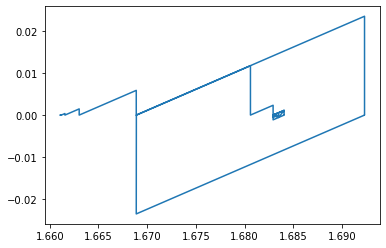

In [13]:
plt.plot(all_y[1:], np.diff(all_y))

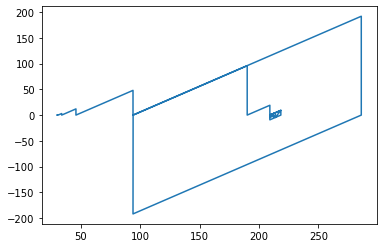

In [12]:
from matplotlib import cm
plt.plot(all_T[1:], np.diff(all_T))

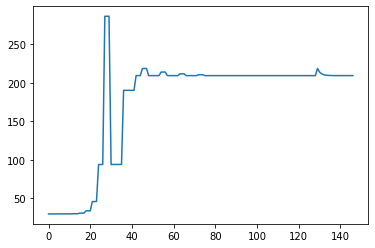

In [14]:
plt.plot(all_T)

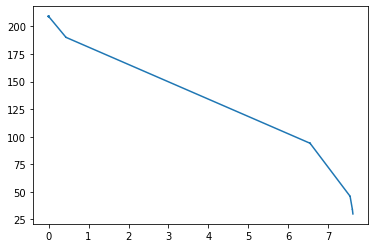

In [18]:
plt.plot(all_P, all_T)

<AxesSubplot:xlabel='Date'>

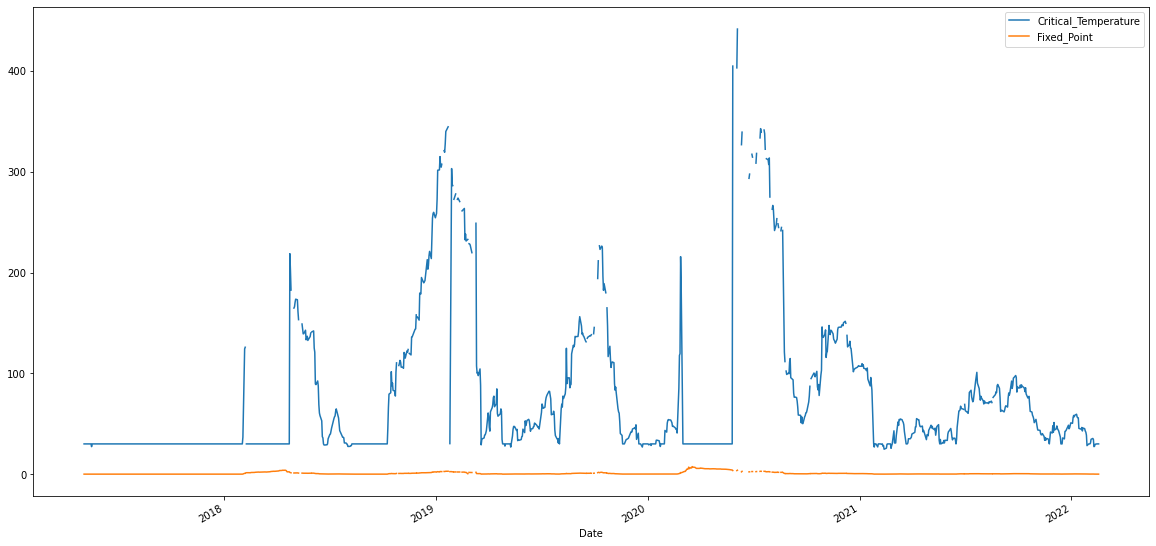

In [13]:
opt_df.plot(figsize=(20,10))

In [14]:
spy_df = yf.Ticker("SPY").history(period="max")
spy_df = spy_df.loc[spy_df.index.intersection(opt_df.index)]['Close']

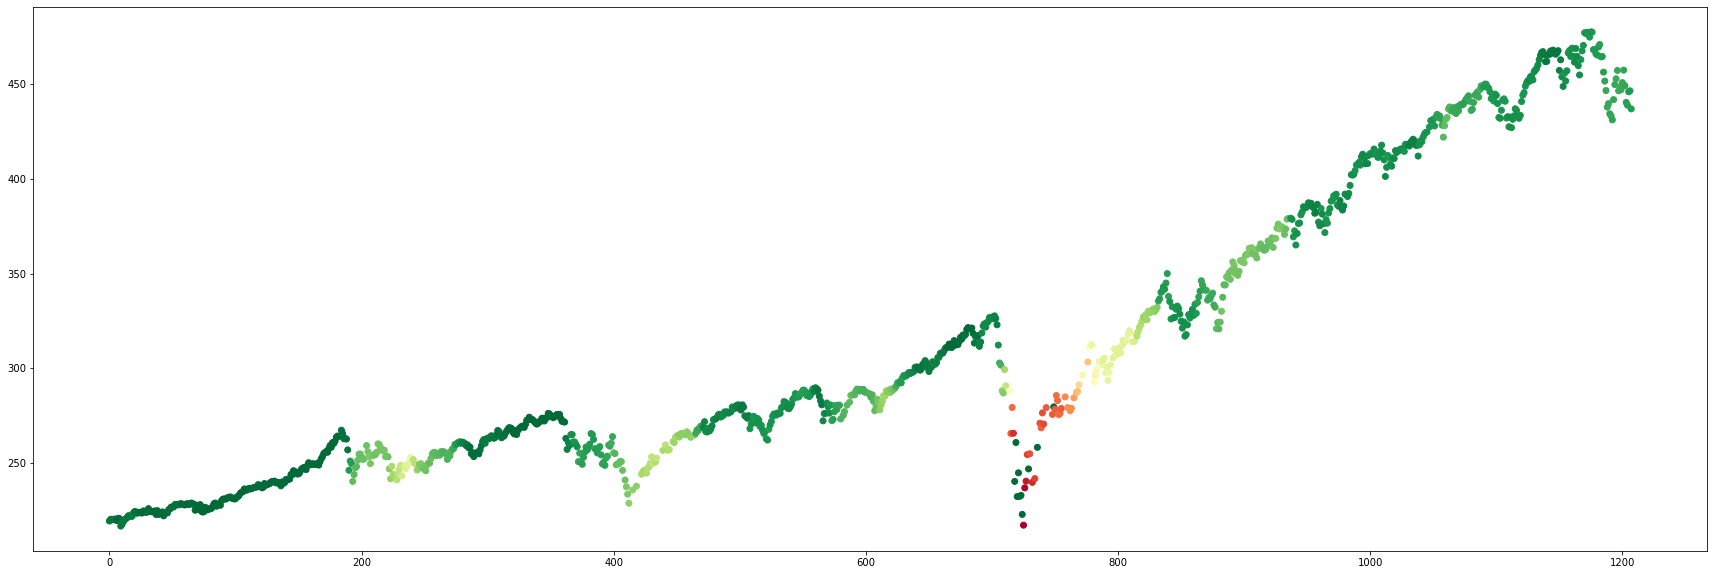

In [34]:
fig = plt.figure(figsize=(30,10))
X = np.arange(spy_df.shape[0])
Y = spy_df.values
plt.scatter(X, Y, c=-opt_df['Critical_Temperature'].values, cmap='RdYlGn')

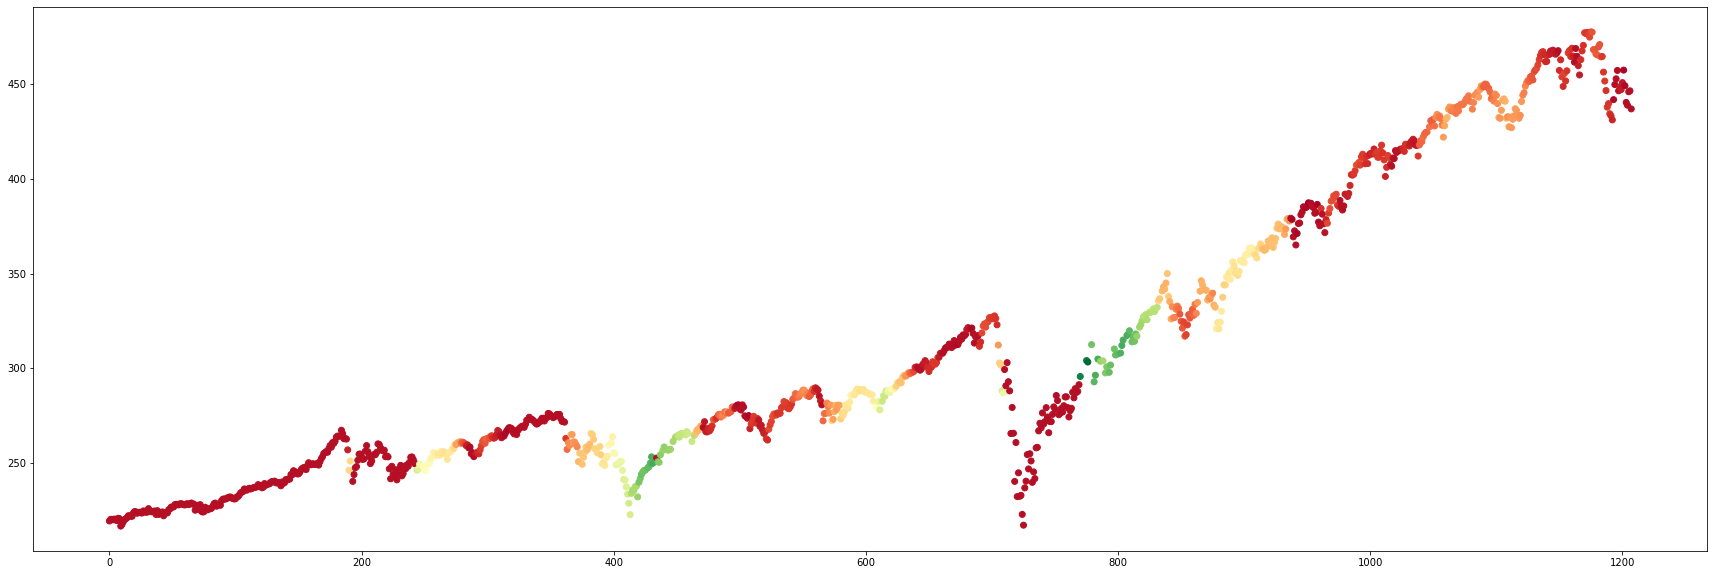

In [25]:
fig = plt.figure(figsize=(30,10))
X = np.arange(spy_df.shape[0])
Y = spy_df.values
plt.scatter(X, Y, c=(opt_df['Critical_Temperature'].values)**.5, cmap='RdYlGn')